In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("../../data/final/Roommate_Compatibility_Survey.csv")
df.head()

,Faculty,Attitude_towards_Roommate_Smoking,Description_of_Personal_Room_At_Home,Desired_Room_Attributes,Bedtime_Preference,Wake_Up_Time_Preference,Planned_Study_Time_Preference,Study_Time_Preference,Private_Time_Requirements,Guest_Frequency_Preference,Conflict_Handling_Method,Communication_Preference_with_Roommate,Age_Categorized
0,0.25,1.0,0.0,0.0,0.333333,1.00,0.666667,0.0,0.5,0.25,1.000000,0.0,0.5
1,0.25,1.0,0.0,0.0,0.666667,0.25,0.333333,0.0,1.0,0.75,0.666667,0.0,0.0
2,0.25,0.0,1.0,0.0,0.666667,0.25,0.666667,1.0,1.0,1.00,0.666667,0.0,0.5
3,0.25,1.0,0.0,0.0,0.666667,0.00,1.000000,0.5,0.0,0.50,0.666667,0.0,0.5
4,0.25,0.5,1.0,0.0,0.666667,0.50,1.000000,0.0,0.5,0.25,1.000000,0.0,0.0


## Kmeans

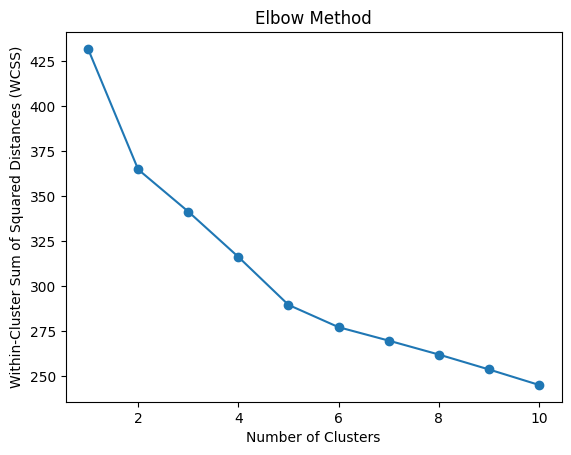

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize an empty list to store the within-cluster sum of squared distances
wcss = []

# Try different values of k from 1 to 10
for i in range(1, 11):
    # Initialize KMeans with the current value of k
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    # Fit KMeans to the data
    kmeans.fit(df)
    
    # Append the WCSS to the list
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squared Distances (WCSS)')
plt.show()


In [21]:
from sklearn.cluster import KMeans
from sklearn import metrics

# Assuming 'df' is your dataset

# Define the number of clusters
k = 5

# Initialize KMeans with the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit KMeans to the data
kmeans.fit(df)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Calculate Davies-Bouldin index
db_index = metrics.davies_bouldin_score(df, labels)

# Calculate silhouette coefficient
silhouette_score = metrics.silhouette_score(df, labels)

# Calculate Calinski-Harabasz index
ch_score = metrics.calinski_harabasz_score(df, labels)

print("Davies-Bouldin index:", db_index)
print("Silhouette coefficient:", silhouette_score)
print("Calinski-Harabasz index:", ch_score)


Davies-Bouldin index: 2.131065244062017
Silhouette coefficient: 0.13728698469396344
Calinski-Harabasz index: 30.519035666519606


In [22]:
from sklearn.cluster import Birch
from sklearn import metrics

# Define the number of clusters
n_clusters = 5

# Initialize BIRCH
birch = Birch(n_clusters=n_clusters)

# Fit BIRCH to the data
birch.fit(df)

# Get the cluster labels for each data point
labels = birch.labels_

# Calculate Davies-Bouldin index
db_index = metrics.davies_bouldin_score(df, labels)

# Calculate silhouette coefficient
silhouette_score = metrics.silhouette_score(df, labels)

# Calculate Calinski-Harabasz index
ch_score = metrics.calinski_harabasz_score(df, labels)

print("Davies-Bouldin index:", db_index)
print("Silhouette coefficient:", silhouette_score)
print("Calinski-Harabasz index:", ch_score)


Davies-Bouldin index: 2.1866068237434337
Silhouette coefficient: 0.12912959889159972
Calinski-Harabasz index: 26.33332832965874


In [25]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Define DBSCAN parameters
epsilon = 0.5  # Epsilon value
min_samples = 2  # MinPts value

# Initialize DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

# Fit DBSCAN to the data
dbscan.fit(df)

# Get the cluster labels for each data point
labels = dbscan.labels_

# Calculate Davies-Bouldin index
db_index = metrics.davies_bouldin_score(df, labels)

# Calculate silhouette coefficient
silhouette_score = metrics.silhouette_score(df, labels)

# Calculate Calinski-Harabasz index
ch_score = metrics.calinski_harabasz_score(df, labels)

print("Davies-Bouldin index:", db_index)
print("Silhouette coefficient:", silhouette_score)
print("Calinski-Harabasz index:", ch_score)


Davies-Bouldin index: 1.4063959003544324
Silhouette coefficient: -0.274730711715029
Calinski-Harabasz index: 1.706953830498588


In [26]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics

# Define the number of clusters
n_clusters = 3

# Initialize GMM
gmm = GaussianMixture(n_components=n_clusters)

# Fit GMM to the data
gmm.fit(df)

# Get the cluster labels for each data point
labels = gmm.predict(df)

# Calculate Davies-Bouldin index
db_index = metrics.davies_bouldin_score(df, labels)

# Calculate silhouette coefficient
silhouette_score = metrics.silhouette_score(df, labels)

# Calculate Calinski-Harabasz index
ch_score = metrics.calinski_harabasz_score(df, labels)

# Print evaluation metrics
print("Davies-Bouldin index:", db_index)
print("Silhouette coefficient:", silhouette_score)
print("Calinski-Harabasz index:", ch_score)


Davies-Bouldin index: 2.808365118046972
Silhouette coefficient: 0.06913373286647333
Calinski-Harabasz index: 25.720385177626184
